In [1]:
import itertools
import pandas as pd
import numpy as np
import toytree
import toyplot
import arviz as az
import pymc3 as pm
from pymc3.distributions.dist_math import normal_lccdf, normal_lcdf
import sproc

In [2]:
# Load tree; drop outgroups, duplicates and tips with no data; and show tip labels.
tree = toytree.tree("/home/henry/oaks-thesis/moto/newick-cal-crown-lambda0_basic_scaffold05.tree")
atree = tree.drop_tips(names = ['Quercus|Quercus|Leucomexicana|Q.laeta', 'Quercus|Lobatae|Erythromexicana|Q.conzattii',
                       'Quercus|Quercus|Leucomexicana|Q.arizonica', 'SRR5984321', 'SRR5632417', 'SRR5632562'])
btree = atree.drop_tips(wildcard = "Chrysolepis")
ctree = btree.drop_tips(wildcard = "Notholithocarpus")
dtree = ctree.drop_tips(wildcard = "Lithocarpus")
etree = dtree.drop_tips(wildcard = "SRR")
ftree = etree.drop_tips(wildcard = "reference")
gtree = ftree.drop_tips(names = ['Quercus|Quercus|Leucomexicana|Q.species', 'Quercus|Quercus|Roburoids|Q.vulcanica',
                                'Quercus|Quercus|Roburoids|Q.imeretina', 'Quercus|Virentes|nan|Q.sagraeana',
                                'Quercus|Lobatae|Erythromexicana|Q.lowilliamsii', 
                                 'Quercus|Lobatae|Agrifoliae|Q.oxyadenia', 'Quercus|Quercus|Roburoids|Q.kotschyana',
                                'Quercus|Quercus|Roburoids|Q.cedrorum', 'Quercus|Quercus|Dumosae|Q.pacifica',
                                 'Quercus|Lobatae|Erythromexicana|Q.sartorii',
                                'Quercus|Lobatae|Agrifoliae|Q.tamalpaiensis','Quercus|Lobatae|Agrifoliae|Q.shrevei',
                                 'Cerris|Cyclobalanopsis|Semiserrata|Q.litoralis', 
                                 'Cerris|Cyclobalanopsis|Acuta|Q.ciliaris', 'Cerris|Cyclobalanopsis|Acuta|Q.stewardiana',
                                'Cerris|Cyclobalanopsis|Semiserrata|Q.patelliformis',
                                'Cerris|Cyclobalanopsis|Glauca|Q.multinervis', 'Cerris|Ilex|Himalayansubalpine|Q.sp.nov.'])

In [3]:
# True param values
𝛼_mean = 0.05
𝛼_std = 0.005
𝛽_mean = 1.5
𝛽_std = 0.05
𝜓_mean = 0.0
𝜓_std = 0.33
𝜎_std = 0.05

In [4]:
# 8 different clade effects on rate of RI (used for partial-pooling data)
𝜓_Quercus_mean = 1.0
𝜓_Quercus_std = 0.2
𝜓_Protobalanus_mean = 0.5
𝜓_Protobalanus_std = 0.1
𝜓_Virentes_mean = -1.0
𝜓_Virentes_std = 1.0
𝜓_Ponticae_mean = -1.0
𝜓_Ponticae_std = 0.1
𝜓_Lobatae_mean = 1.0
𝜓_Lobatae_std = 0.2
𝜓_Cyclobalanopsis_mean = 1.0
𝜓_Cyclobalanopsis_std = 0.2
𝜓_Ilex_mean = 0.5
𝜓_Ilex_std = 0.1
𝜓_Cerris_mean = 0.5
𝜓_Cerris_std = 0.1

In [5]:
# Get crown nodes for eight clades.
crowns = [
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Quercus"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Virentes"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Ponticae"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Protobalanus"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Lobatae"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Cerris|Cyclobalanopsis"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Cerris|Ilex"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Cerris|Cerris")
]
crowns

[393, 394, 405, 417, 425, 426, 422, 423]

In [6]:
# Dict to set clade indices.
clades = {
    "Quercus" : 0,
    "Virentes" : 1,
    "Ponticae" : 2,
    "Protobalanus" : 3,
    "Lobatae" : 4,
    "Cyclobalanopsis" : 5,
    "Ilex" : 6,
    "Cerris" : 7
}

In [7]:
tips = len(gtree.get_tip_labels())
Cerris_tips = len(gtree.get_tip_labels(423))
Ilex_tips = len(gtree.get_tip_labels(422))
Cyclobalanopsis_tips = len(gtree.get_tip_labels(426))
Lobatae_tips = len(gtree.get_tip_labels(425))
Protobalanus_tips = len(gtree.get_tip_labels(417))
Ponticae_tips = len(gtree.get_tip_labels(405))
Virentes_tips = len(gtree.get_tip_labels(394))
Quercus_tips = len(gtree.get_tip_labels(393))

In [8]:
SPECIES_DATA = pd.DataFrame({
    "Species": ["Quercus " + "{}".format(
        gtree.idx_dict[idx].name.split("|")[-1].split(".")[-1]) for idx in range(len(gtree.get_tip_labels()))],
    "𝛽": np.random.normal(𝛽_mean, 𝛽_std, tips),
    "𝜓": np.random.normal(𝜓_mean, 𝜓_std, tips),
    "𝜓_x": np.concatenate([
        np.random.normal(𝜓_Quercus_mean, 𝜓_Quercus_std, Quercus_tips),
        np.random.normal(𝜓_Virentes_mean, 𝜓_Virentes_std, Virentes_tips),
        np.random.normal(𝜓_Ponticae_mean, 𝜓_Ponticae_std, Ponticae_tips),
        np.random.normal(𝜓_Protobalanus_mean, 𝜓_Protobalanus_std, Protobalanus_tips),
        np.random.normal(𝜓_Lobatae_mean, 𝜓_Lobatae_std, Lobatae_tips),
        np.random.normal(𝜓_Cyclobalanopsis_mean, 𝜓_Cyclobalanopsis_std, Cyclobalanopsis_tips),
        np.random.normal(𝜓_Ilex_mean, 𝜓_Ilex_std, Ilex_tips),
        np.random.normal(𝜓_Cerris_mean, 𝜓_Cerris_std, Cerris_tips),
    ]),
    "gidx": np.concatenate([
        np.repeat(0, Quercus_tips),
        np.repeat(1, Virentes_tips),
        np.repeat(2, Ponticae_tips),
        np.repeat(3, Protobalanus_tips),
        np.repeat(4, Lobatae_tips),
        np.repeat(5, Cyclobalanopsis_tips),
        np.repeat(6, Ilex_tips),
        np.repeat(7, Cerris_tips),
    ]),
})

# species RI velocity is the base velocity times species specific 
SPECIES_DATA["velo"] = SPECIES_DATA["𝛽"] + SPECIES_DATA["𝜓"]
SPECIES_DATA["velo_x"] = SPECIES_DATA["𝛽"] + SPECIES_DATA["𝜓_x"]
SPECIES_DATA.head()

,Species,𝛽,𝜓,𝜓_x,gidx,velo,velo_x
0,Quercus aj...,1.452289,-0.008773,0.997958,0,1.443516,2.450247
1,Quercus tu...,1.514740,-0.018364,1.025402,0,1.496376,2.540141
2,Quercus to...,1.450455,0.483043,1.004585,0,1.933498,2.455040
3,Quercus ob...,1.421680,0.303747,0.771512,0,1.725426,2.193192
4,Quercus ch...,1.415580,-0.092214,0.971652,0,1.323367,2.387233


In [17]:
ranges = [sproc.Sproc(species=spp, workdir="/tmp", scalar=2.5) for spp in SPECIES_DATA['Species']]

12:54 | INFO    | __init__        | fetched 39 occurrence records
12:54 | INFO    | _mark_outliers  | dropped outliers: 0
12:54 | INFO    | write           | wrote data to /tmp/Quercus_ajoensis.json
12:54 | INFO    | __init__        | fetched 1060 occurrence records
12:54 | INFO    | _mark_outliers  | dropped outliers: 37
12:54 | INFO    | write           | wrote data to /tmp/Quercus_turbinella.json
12:54 | INFO    | __init__        | fetched 177 occurrence records
12:54 | INFO    | _mark_outliers  | dropped outliers: 2
12:54 | INFO    | write           | wrote data to /tmp/Quercus_toumeyi.json
12:54 | INFO    | __init__        | fetched 302 occurrence records
12:54 | INFO    | _mark_outliers  | dropped outliers: 86
12:54 | INFO    | write           | wrote data to /tmp/Quercus_oblongifolia.json
12:54 | INFO    | __init__        | fetched 390 occurrence records
12:54 | INFO    | _mark_outliers  | dropped outliers: 99
12:54 | INFO    | write           | wrote data to /tmp/Quercus_chihua

12:56 | INFO    | _mark_outliers  | dropped outliers: 4
12:56 | INFO    | write           | wrote data to /tmp/Quercus_germana.json
12:56 | INFO    | __init__        | fetched 249 occurrence records
12:56 | INFO    | _mark_outliers  | dropped outliers: 1
12:56 | INFO    | write           | wrote data to /tmp/Quercus_martinezii.json
12:56 | INFO    | __init__        | fetched 914 occurrence records
12:56 | INFO    | _mark_outliers  | dropped outliers: 341
12:56 | INFO    | write           | wrote data to /tmp/Quercus_stellata.json
12:56 | INFO    | __init__        | fetched 7 occurrence records
12:56 | INFO    | _mark_outliers  | dropped outliers: 0
12:56 | INFO    | write           | wrote data to /tmp/Quercus_boyntonii.json
12:56 | INFO    | __init__        | fetched 19 occurrence records
12:56 | INFO    | _mark_outliers  | dropped outliers: 0
12:56 | INFO    | write           | wrote data to /tmp/Quercus_similis.json
12:56 | INFO    | __init__        | fetched 79 occurrence records
1

12:59 | INFO    | __init__        | fetched 3513 occurrence records
12:59 | INFO    | _mark_outliers  | dropped outliers: 3279
12:59 | INFO    | write           | wrote data to /tmp/Quercus_petraea.json
12:59 | INFO    | __init__        | fetched 916 occurrence records
12:59 | INFO    | _mark_outliers  | dropped outliers: 269
12:59 | INFO    | write           | wrote data to /tmp/Quercus_fabri.json
12:59 | INFO    | __init__        | fetched 1376 occurrence records
12:59 | INFO    | _mark_outliers  | dropped outliers: 1169
12:59 | INFO    | write           | wrote data to /tmp/Quercus_aliena.json
12:59 | INFO    | __init__        | fetched 172 occurrence records
12:59 | INFO    | _mark_outliers  | dropped outliers: 0
12:59 | INFO    | write           | wrote data to /tmp/Quercus_griffithii.json
12:59 | INFO    | __init__        | fetched 10 occurrence records
12:59 | INFO    | _mark_outliers  | dropped outliers: 0
12:59 | INFO    | write           | wrote data to /tmp/Quercus_yunnanens

01:01 | INFO    | write           | wrote data to /tmp/Quercus_sadleriana.json
01:02 | INFO    | __init__        | fetched 2142 occurrence records
01:02 | INFO    | _mark_outliers  | dropped outliers: 15
01:02 | INFO    | write           | wrote data to /tmp/Quercus_chrysolepis.json
01:02 | INFO    | __init__        | fetched 403 occurrence records
01:02 | INFO    | _mark_outliers  | dropped outliers: 10
01:02 | INFO    | write           | wrote data to /tmp/Quercus_tomentella.json
01:02 | INFO    | __init__        | fetched 545 occurrence records
01:02 | INFO    | _mark_outliers  | dropped outliers: 2
01:02 | INFO    | write           | wrote data to /tmp/Quercus_vacciniifolia.json
01:02 | INFO    | __init__        | fetched 424 occurrence records
01:02 | INFO    | _mark_outliers  | dropped outliers: 14
01:02 | INFO    | write           | wrote data to /tmp/Quercus_palmeri.json
01:02 | INFO    | __init__        | fetched 281 occurrence records
01:02 | INFO    | _mark_outliers  | dropp

01:03 | INFO    | __init__        | fetched 216 occurrence records
01:03 | INFO    | _mark_outliers  | dropped outliers: 6
01:03 | INFO    | write           | wrote data to /tmp/Quercus_durifolia.json
01:03 | INFO    | __init__        | fetched 554 occurrence records
01:03 | INFO    | _mark_outliers  | dropped outliers: 24
01:03 | INFO    | write           | wrote data to /tmp/Quercus_scytophylla.json
01:03 | INFO    | __init__        | fetched 1121 occurrence records
01:03 | INFO    | _mark_outliers  | dropped outliers: 22
01:03 | INFO    | write           | wrote data to /tmp/Quercus_acutifolia.json
01:04 | INFO    | __init__        | fetched 887 occurrence records
01:04 | INFO    | _mark_outliers  | dropped outliers: 13
01:04 | INFO    | write           | wrote data to /tmp/Quercus_eduardi.json
01:04 | INFO    | __init__        | fetched 207 occurrence records
01:04 | INFO    | _mark_outliers  | dropped outliers: 0
01:04 | INFO    | write           | wrote data to /tmp/Quercus_fulva

01:05 | INFO    | write           | wrote data to /tmp/Quercus_pagoda.json
01:05 | INFO    | __init__        | fetched 38 occurrence records
01:05 | INFO    | _mark_outliers  | dropped outliers: 3
01:05 | INFO    | write           | wrote data to /tmp/Quercus_buckleyi.json
01:05 | INFO    | __init__        | fetched 697 occurrence records
01:05 | INFO    | _mark_outliers  | dropped outliers: 187
01:05 | INFO    | write           | wrote data to /tmp/Quercus_coccinea.json
01:06 | INFO    | __init__        | fetched 2816 occurrence records
01:06 | INFO    | _mark_outliers  | dropped outliers: 790
01:06 | INFO    | write           | wrote data to /tmp/Quercus_rubra.json
01:06 | INFO    | __init__        | fetched 23 occurrence records
01:06 | INFO    | _mark_outliers  | dropped outliers: 0
01:06 | INFO    | write           | wrote data to /tmp/Quercus_acerifolia.json
01:06 | INFO    | __init__        | fetched 652 occurrence records
01:06 | INFO    | _mark_outliers  | dropped outliers: 22

01:07 | INFO    | _mark_outliers  | dropped outliers: 476
01:07 | INFO    | write           | wrote data to /tmp/Quercus_myrsinifolia.json
01:07 | INFO    | __init__        | fetched 15 occurrence records
01:07 | INFO    | _mark_outliers  | dropped outliers: 0
01:07 | INFO    | write           | wrote data to /tmp/Quercus_kouangsiensis.json
01:07 | INFO    | __init__        | fetched 9 occurrence records
01:07 | INFO    | _mark_outliers  | dropped outliers: 0
01:07 | INFO    | write           | wrote data to /tmp/Quercus_chrysocalyx.json
01:07 | INFO    | __init__        | fetched 29 occurrence records
01:07 | INFO    | _mark_outliers  | dropped outliers: 16
01:07 | INFO    | write           | wrote data to /tmp/Quercus_annulata.json
01:07 | INFO    | __init__        | fetched 526 occurrence records
01:07 | INFO    | _mark_outliers  | dropped outliers: 306
01:07 | INFO    | write           | wrote data to /tmp/Quercus_oxyodon.json
01:08 | INFO    | __init__        | fetched 599 occurre

01:09 | INFO    | __init__        | fetched 126 occurrence records
01:09 | INFO    | _mark_outliers  | dropped outliers: 0
01:09 | INFO    | write           | wrote data to /tmp/Quercus_baronii.json
01:09 | INFO    | __init__        | fetched 138 occurrence records
01:09 | INFO    | _mark_outliers  | dropped outliers: 5
01:09 | INFO    | write           | wrote data to /tmp/Quercus_phillyreoides.json
01:09 | INFO    | __init__        | fetched 138 occurrence records
01:09 | INFO    | _mark_outliers  | dropped outliers: 4
01:09 | INFO    | write           | wrote data to /tmp/Quercus_franchetii.json
01:09 | INFO    | __init__        | fetched 57 occurrence records
01:09 | INFO    | _mark_outliers  | dropped outliers: 14
01:09 | INFO    | write           | wrote data to /tmp/Quercus_libani.json
01:09 | INFO    | __init__        | fetched 11 occurrence records
01:09 | INFO    | _mark_outliers  | dropped outliers: 0
01:09 | INFO    | write           | wrote data to /tmp/Quercus_look.json
0

In [19]:
SPECIES_DATA

,Species,𝛽,𝜓,𝜓_x,gidx,velo,velo_x,sproc
0,Quercus aj...,1.452289,-0.008773,0.997958,0,1.443516,2.450247,<Sproc spp...
1,Quercus tu...,1.514740,-0.018364,1.025402,0,1.496376,2.540141,<Sproc spp...
2,Quercus to...,1.450455,0.483043,1.004585,0,1.933498,2.455040,<Sproc spp...
3,Quercus ob...,1.421680,0.303747,0.771512,0,1.725426,2.193192,<Sproc spp...
4,Quercus ch...,1.415580,-0.092214,0.971652,0,1.323367,2.387233,<Sproc spp...
...,...,...,...,...,...,...,...,...
211,Quercus ma...,1.528628,-0.228115,0.286585,7,1.300513,1.815213,<Sproc spp...
212,Quercus br...,1.453094,0.030733,0.468157,7,1.483826,1.921251,<Sproc spp...
213,Quercus it...,1.520137,-0.212161,0.456401,7,1.307976,1.976538,<Sproc spp...
214,Quercus ac...,1.416936,-0.354259,0.470816,7,1.062676,1.887752,<Sproc spp...


In [22]:
NSAMPLES = 5000
RNG = np.random.default_rng(123)

In [336]:
# sample random cross pairs
crosses = RNG.choice(gtree.get_tip_labels(), size=(NSAMPLES, 2))

# translate names to indices
name2nidx = gtree.get_feature_dict("name", "idx")

# randomly choose tip idx numbers maternal and paternal
data = pd.DataFrame({
    "sp0": crosses[:, 0],
    "sp1": crosses[:, 1],
    "sidx0": [name2nidx[i] for i in crosses[:, 0]],
    "sidx1": [name2nidx[i] for i in crosses[:, 1]],
    "genetic_dist": 0.,
    "geo_overlap": [SPECIES_DATA[SPECIES_DATA['Species'] == "Quercus " + data.loc[
    idx, 'sp0'].split("|")[-1].split(".")[-1]]['sproc'][data.loc[idx, 'sidx0']].georange.intersects(
SPECIES_DATA[SPECIES_DATA['Species'] == "Quercus " + data.loc[
    idx, 'sp1'].split("|")[-1].split(".")[-1]]['sproc'][data.loc[idx, 'sidx1']].georange) for idx in data.index]
})

In [338]:
def get_dist(tree, idx0, idx1):
    "returns the genetic distance between two nodes on a tree"
    dist = tree.treenode.get_distance(
        tree.idx_dict[idx0], 
        tree.idx_dict[idx1],
    )
    return dist

In [339]:
# calc genetic distances and normalize to range(0, 1)
data['genetic_dist'] = [get_dist(gtree, *data.iloc[idx, [2, 3]]) / 2 for idx in data.index]
data['genetic_dist'] += data['genetic_dist'].min()
data['genetic_dist'] /= data['genetic_dist'].max()

In [340]:
intercept = RNG.normal(𝛼_mean, 𝛼_std, data.shape[0])
error = RNG.normal(0.0, 𝜎_std, data.shape[0])
data['RI_pooled'] = data.genetic_dist * SPECIES_DATA.loc[data.sidx0, "𝛽"].values
data['RI_pooled'] += intercept + error
data['RI_unpooled'] = data.genetic_dist * SPECIES_DATA.loc[data.sidx0, "velo"].values
data['RI_unpooled'] += intercept + error
data['RI_groups'] = data.genetic_dist * SPECIES_DATA.loc[data.sidx0, "velo_x"].values
data['RI_groups'] += intercept + error

In [341]:
# censor values in range 0-1
data.loc[data['RI_pooled'] < 0, 'RI_pooled'] = 0
data.loc[data['RI_pooled'] > 1, 'RI_pooled'] = 1
data.loc[data['RI_unpooled'] < 0, 'RI_unpooled'] = 0
data.loc[data['RI_unpooled'] > 1, 'RI_unpooled'] = 1
data.loc[data['RI_groups'] < 0, 'RI_groups'] = 0
data.loc[data['RI_groups'] > 1, 'RI_groups'] = 1

In [176]:
data['geo_overlap'] = data['geo_overlap'].astype(np.int64)

In [342]:
data

,sp0,sp1,sidx0,sidx1,genetic_dist,geo_overlap,RI_pooled,RI_unpooled,RI_groups
0,Quercus|Qu...,Quercus|Lo...,44,126,0.927411,False,1.000000,1.000000,1.000000
1,Quercus|Qu...,Cerris|Cer...,29,206,1.000000,True,1.000000,1.000000,1.000000
2,Quercus|Lo...,Cerris|Ile...,128,196,1.000000,True,1.000000,1.000000,1.000000
3,Quercus|Qu...,Cerris|Cyc...,68,182,1.000000,False,1.000000,1.000000,1.000000
4,Quercus|Lo...,Quercus|Qu...,116,47,0.927411,False,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...
4995,Quercus|Qu...,Quercus|Lo...,49,104,0.927411,False,1.000000,1.000000,1.000000
4996,Quercus|Lo...,Quercus|Lo...,119,143,0.063320,False,0.049309,0.032472,0.107998
4997,Quercus|Qu...,Cerris|Cyc...,14,169,1.000000,True,1.000000,0.974550,1.000000
4998,Quercus|Qu...,Quercus|Lo...,65,142,0.927411,False,1.000000,1.000000,1.000000


In [84]:
def toytrace(trace, var_names, titles):
    """
    Plot posterior trace with toyplot
    """
    nvars = len(var_names)
    
    # setup canvase
    canvas = toyplot.Canvas(width=500, height=200 * nvars)
    
    # store axes
    axes = []
    
    # iter over params
    for pidx, param in enumerate(var_names):
        
        # get param posterior
        posterior = trace.get_values(param)
        
        # setup axes 
        ax = canvas.cartesian(grid=(nvars, 1, pidx))
        ax.y.show = False
        ax.x.spine.style = {"stroke-width": 1.5}
        ax.x.ticks.labels.style = {"font-size": "12px"}
        ax.x.ticks.show = True
        ax.x.label.text = f"param='{titles[pidx]}'"        
        
        # iterate over shape of param
        for idx in range(posterior.shape[1]):
            mags, bins = np.histogram(posterior[:, idx], bins=100)
            ax.plot(bins[1:], mags, stroke_width=2, opacity=0.6)
        axes.append(ax)
    return canvas, axes

In [85]:
def censored_pooled_regression(x, y, **kwargs):
    
    # data pre-processing
    lower_censored = y[y <= 0].index
    _x_lc = x[lower_censored].values
    _y_lc = y[lower_censored].values

    upper_censored = y[y >= 1].index
    _x_uc = x[upper_censored].values
    _y_uc = y[upper_censored].values

    uncensored = (y > 0) & (y < 1)
    _x = x[uncensored].values
    _y = y[uncensored].values
    
    # define model
    with pm.Model() as model:  

        # parameters and error
        𝛼 = pm.Normal('𝛼', mu=0., sigma=10., shape=1)
        𝛽 = pm.Normal('𝛽', mu=0., sigma=10., shape=1)
        𝜎 = pm.HalfNormal('𝜎', 5.0, shape=1)

        # linear model prediction
        ri = 𝛼 + 𝛽 * _x

        # data likelihood (normal distributed errors)
        y = pm.Normal("y", mu=ri, sigma=𝜎, observed=_y)

        # density of censored data
        if sum(lower_censored):
            lcensored = pm.Potential(
                "lower_censored", 
                normal_lcdf(𝛼 + 𝛽 * _x_lc, 𝜎, _y_lc),
            )
        if sum(upper_censored):
            ucensored = pm.Potential(
                "upper_censored",
                normal_lccdf(𝛼 + 𝛽 * _x_uc, 𝜎, _y_uc),
            )

        # sample posterior, skip burnin
        trace = pm.sample(**kwargs)[1000:]
    
        # show summary table
        stats = pm.summary(trace)
        
    # organize results
    result_dict = {
        'model': model, 
        'trace': trace,
        'stats': stats,
    }
    return result_dict

In [347]:
lower_censored = data.RI_unpooled[data.RI_unpooled <= 0].index
upper_censored = data.RI_unpooled[data.RI_unpooled >=1].index
uncensored = (data.RI_unpooled > 0) & (data.RI_unpooled < 1)
data.geo_overlap[lower_censored].values

array([ True,  True, False, False, False,  True, False,  True, False,
        True,  True, False, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  True])

In [365]:
def censored_unpooled_noncentered_regression(x, y, idx0, idx1, **kwargs):
    
    # data pre-processing
    lower_censored = y[y <= 0].index
    _x_lc = x[lower_censored].values
    _y_lc = y[lower_censored].values

    upper_censored = y[y >= 1].index
    _x_uc = x[upper_censored].values
    _y_uc = y[upper_censored].values

    uncensored = (y > 0) & (y < 1)
    _x = x[uncensored].values
    _y = y[uncensored].values
    
    # define model
    with pm.Model() as model:
        
        # censored indexers
        sidx0 = pm.Data("spp_idx0", idx0.values[uncensored])
        sidx1 = pm.Data("spp_idx1", idx1.values[uncensored])
        sidx0_u = pm.Data("sidx0_u", idx0.values[upper_censored])
        sidx1_u = pm.Data("sidx1_u", idx1.values[upper_censored])
        sidx0_l = pm.Data("sidx0_l", idx0.values[lower_censored])
        sidx1_l = pm.Data("sidx1_l", idx1.values[lower_censored])

        # parameters and error
        𝜓_mean = pm.Normal('𝜓_mean', mu=0., sigma=5., shape=1)
        𝜓_std = pm.HalfNormal('𝜓_std', 5., shape=1)
        𝜓_offset = pm.Normal('𝜓_offset', mu=0, sigma=1., shape=tips)
        𝜓 = pm.Deterministic('𝜓', 𝜓_mean + 𝜓_std * 𝜓_offset)
        𝛽 = pm.Normal('𝛽', mu=0., sigma=10., shape=1)
        𝛼 = pm.Normal('𝛼', mu=0., sigma=10., shape=1)
        𝜎 = pm.HalfNormal('𝜎', 5., shape=1)
        
        # linear model prediction
        ri = 𝛼 + (𝛽 + 𝜓[sidx0] + 𝜓[sidx1]) * _x

        # data likelihood (normal distributed errors)
        y = pm.Normal("y", mu=ri, sigma=𝜎, observed=_y)

        # density of censored data
        if sum(lower_censored):
            lcensored = pm.Potential(
                "lower_censored", 
                normal_lcdf(𝛼 + (𝛽 + 𝜓[sidx0_l] + 𝜓[sidx1_l]) * _x_lc, 𝜎, _y_lc),
            )
        
        if sum(upper_censored):
            ucensored = pm.Potential(
                "upper_censored",
                normal_lccdf(𝛼 + (𝛽 + 𝜓[sidx0_u] + 𝜓[sidx1_u]) * _x_uc, 𝜎, _y_uc),
            )

        # sample posterior, skip burnin
        trace = pm.sample(**kwargs)[1000:]

        # show summary table
        stats = pm.summary(trace)
        
    # organize results
    result_dict = {
        'model': model, 
        'trace': trace,
        'stats': stats,
    }
    return result_dict

In [372]:
def censored_partpooled_noncentered_regression(x, y, idx0, idx1, gidx, **kwargs):
    
    # data pre-processing
    lower_censored = y[y <= 0].index
    _x_lc = x[lower_censored].values
    _y_lc = y[lower_censored].values

    upper_censored = y[y >= 1].index
    _x_uc = x[upper_censored].values
    _y_uc = y[upper_censored].values

    uncensored = (y > 0) & (y < 1)
    _x = x[uncensored].values
    _y = y[uncensored].values
    
    # define model
    with pm.Model() as model:
        
        # censored indexers
        sidx0 = pm.Data("spp_idx0", idx0.values[uncensored])
        sidx1 = pm.Data("spp_idx1", idx1.values[uncensored])
        sidx0_u = pm.Data("sidx0_u", idx0.values[upper_censored])
        sidx1_u = pm.Data("sidx1_u", idx1.values[upper_censored])
        sidx0_l = pm.Data("sidx0_l", idx0.values[lower_censored])
        sidx1_l = pm.Data("sidx1_l", idx1.values[lower_censored])
        gidx = pm.Data("gidx", gidx)

        # parameters and error
        𝜓_mean = pm.Normal('𝜓_mean', mu=0., sigma=5., shape=8)
        𝜓_std = pm.HalfNormal('𝜓_std', 5., shape=8)
        𝜓_offset = pm.Normal('𝜓_offset', mu=0, sigma=1., shape=tips)
        𝜓 = pm.Deterministic('𝜓', 𝜓_mean[gidx] + 𝜓_std[gidx] * 𝜓_offset)
        𝛽 = pm.Normal('𝛽', mu=0., sigma=10., shape=1)
        𝛼 = pm.Normal('𝛼', mu=0., sigma=10., shape=1)
        𝜎 = pm.HalfNormal('𝜎', 5., shape=1)
        
        # linear model prediction
        ri = 𝛼 + (𝛽 + 𝜓[sidx0] + 𝜓[sidx1]) * _x

        # data likelihood (normal distributed errors)
        y = pm.Normal("y", mu=ri, sigma=𝜎, observed=_y)

        # density of censored data
        if sum(lower_censored):
            lcensored = pm.Potential(
                "lower_censored", 
                normal_lcdf(𝛼 + (𝛽 + 𝜓[sidx0_l] + 𝜓[sidx1_l]) * _x_lc, 𝜎, _y_lc),
            )
        
        if sum(upper_censored):
            ucensored = pm.Potential(
                "upper_censored",
                normal_lccdf(𝛼 + (𝛽 + 𝜓[sidx0_u] + 𝜓[sidx1_u]) * _x_uc, 𝜎, _y_uc),
            )

        # sample posterior, skip burnin
        trace = pm.sample(**kwargs)[1000:]

        # show summary table
        stats = pm.summary(trace)
        
    # organize results
    result_dict = {
        'model': model, 
        'trace': trace,
        'stats': stats,
    }
    return result_dict

In [89]:
# MCMC sampler kwargs
sample_kwargs = dict(
    tune=4000,
    draws=4000,
    target_accept=0.95,
    return_inferencedata=False,
    progressbar=True,
)

In [90]:
# model input
model_args = [
    data.genetic_dist,
    data.RI_pooled,
    data.sidx0,
    data.sidx1,
    SPECIES_DATA.gidx,
]

# fit pooled model to pooled data
pooled = censored_pooled_regression(*model_args[:2], **sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝜎, 𝛽, 𝛼]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 188 seconds.


In [271]:
pooled['stats']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
𝛼[0],0.048,0.003,0.043,0.053,0.0,0.0,5199.0,5182.0,5193.0,6352.0,1.0
𝛽[0],1.498,0.007,1.485,1.512,0.0,0.0,5329.0,5329.0,5330.0,6187.0,1.0
𝜎[0],0.051,0.001,0.049,0.054,0.0,0.0,7449.0,7437.0,7462.0,6953.0,1.0


In [366]:
model_args = [
    data.genetic_dist,
    data.RI_unpooled,
    data.sidx0,
    data.sidx1,
    SPECIES_DATA.gidx,
]

# run models
unpooled = censored_unpooled_noncentered_regression(*model_args[:4], **sample_kwargs)

INFO (theano.gof.compilelock): Refreshing lock /home/henry/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.9-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝜎, 𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 21557 seconds.
INFO (theano.gof.compilelock): Refreshing lock /home/henry/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.9-64/lock_dir/lock
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_ac

In [368]:
RI_ESTIMATE = (
    unpooled['trace']['𝛽'] + 
    unpooled['trace']['𝜓_mean'] + 
    unpooled['trace']['𝜓_std'] * 
    unpooled['trace']['𝜓_offset'].mean(axis=0)
).mean(axis=0)

# show plot of TRUE vs. ESTIMATED rates
toyplot.scatterplot(
    SPECIES_DATA.velo,
    RI_ESTIMATE,
    width=400,
    height=250,
    xlabel="TRUE species velocity",
    ylabel="ESTIMATED species velocity"
);

<svg class="toyplot-canvas-Canvas" height="250.0px" id="ta87e8e24909444668830112bf68df56d" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 400.0 250.0" width="400.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0.5 1.0 1.5 2.0 2.5 TRUE species velocity 0.4 0.6 0.8 1.0 1.2 ESTIMATED species velocity

In [373]:
# model input
model_args = [
    data.genetic_dist,
    data.RI_groups,
    data.sidx0,
    data.sidx1,
    SPECIES_DATA.gidx,
]

partpooled = censored_partpooled_noncentered_regression(*model_args, **sample_kwargs)

INFO (theano.gof.compilelock): Refreshing lock /home/henry/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.9-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝜎, 𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 22879 seconds.
INFO (theano.gof.compilelock): Refreshing lock /home/henry/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.9-64/lock_dir/lock
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


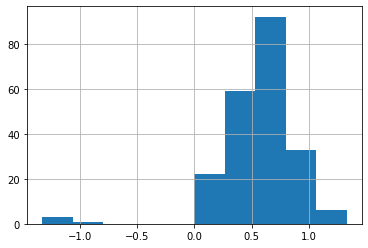

In [386]:
pm.summary(partpooled['trace'], var_names = '𝜓')['mean'].hist();

In [376]:
RI_ESTIMATE = (
    partpooled['trace']['𝛽'] + 
    partpooled['trace']['𝜓_mean'][:, SPECIES_DATA.gidx] + 
    partpooled['trace']['𝜓_std'][:, SPECIES_DATA.gidx] * 
    partpooled['trace']['𝜓_offset'].mean(axis=0)
).mean(axis=0)

In [377]:
# show plot of TRUE vs. ESTIMATED rates
toyplot.scatterplot(
    SPECIES_DATA.velo_x,
    RI_ESTIMATE,
    width=400,
    height=250,
    xlabel="TRUE species velocity",
    ylabel="ESTIMATED species velocity",
    color=[toyplot.color.Palette()[i] for i in SPECIES_DATA.gidx],
);

<svg class="toyplot-canvas-Canvas" height="250.0px" id="tb46842a6a8334bc4a7d6e05004a8efe8" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 400.0 250.0" width="400.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0 1 2 3 TRUE species velocity 0 1 2 3 ESTIMATED species velocity